[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/TransformerLensOrg/TransformerLens/blob/main/demos/Exploratory_Analysis_Demo.ipynb)

# ​Extending the Linear Representation Hypothesis via Transcoder-Style SAEs and Feature Steering on Hallucinations on the LAMBADA Dataset

This notebook demonstrates an extension of the LRH using Transcoder-Style Sparse Autoencoders (SAEs) by steering features in GPT-2 associated with hallucinations to demonstrate such steering can influence model outputs. The benchmark dataset used is the LAMBADA dataset, which contains cloze-style (i.e. 'fill-in-the-blank) problems. This notebook takes inspiration from the
[TransformerLens](https://github.com/TransformerLensOrg/TransformerLens/) library's [Exploratory Analysis demo Colab Notebook](https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Exploratory_Analysis_Demo.ipynb).

## Setup

### Environment Setup

**Note**: Be sure to switch runtime to use a GPU for faster compute (e.g. T4 GPU)

In [1]:
!pip install transformer_lens
!pip install circuitsvis
!pip install sae-lens
!pip install pandas
!pip uninstall -y numpy
!pip install numpy==1.26.4 # Newer numpy versions have dependency conflicts with pandas
# Install a faster Node version
!curl -fsSL https://deb.nodesource.com/setup_21.x | sudo -E bash -; sudo apt-get install -y nodejs  # noqa

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
2025-04-23 00:14:24 - Installing pre-requisites
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:6 https://deb.nodesource

### Imports

**Important Note**: Sometimes numpy fails to use the specified version (v1.26.4) after being imported, which causes an error when importing the rest of the libraries due to dependency conflicts.  If the following doesn't print '1.26.4', then restart session via: 'Runtime' --> 'Restart Session' to fix the issue.

In [2]:
import numpy as np
print(np.__version__) # Should be 1.26.4
assert np.__version__ == '1.26.4'

1.26.4


The above block should have printed '1.26.4'.  If not, then restart session via 'Runtime' --> 'Restart Session'.  Else, continue.



In [3]:
import torch
import scipy
import matplotlib.pyplot as plt
from tqdm import tqdm
from datasets import load_dataset
import transformer_lens.utils as utils
from transformer_lens import ActivationCache, HookedTransformer
from sae_lens import SAE

### PyTorch Setup

We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [4]:
torch.set_grad_enabled(False)
print("Disabled automatic differentiation")

Disabled automatic differentiation


### Model and Dataset Import

In [5]:
# NBVAL_IGNORE_OUTPUT
model = HookedTransformer.from_pretrained("gpt2-small")
model.eval()

# Get the default device used
device: torch.device = utils.get_device()
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (h

In [6]:
lambada = load_dataset("lambada", split="test")

# Inspect a sample problem
example_prompt, example_answer = lambada[0]['text'].rsplit(' ', 1)
print('Question: ' + example_prompt + '\n')
print('Answer: ' + example_answer)

Generating train split:   0%|          | 0/2662 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5153 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4869 [00:00<?, ? examples/s]

Question: in my palm is a clear stone , and inside it is a small ivory statuette . a guardian angel . `` figured if you 're going to be out at night getting hit by cars , you might as well have some backup . '' i look at him , feeling stunned . like this is some sort of sign . but as i stare at harlin , his mouth curved in a confident grin , i do n't care about

Answer: signs


We verify that our model can 'do' a task from this (LAMBADA) dataset (note that not all tasks may pass; we just want to verify that the model can do at least one of the tasks):

In [7]:
example_prompt, example_answer = lambada[8]['text'].rsplit(' ', 1)
utils.test_prompt(example_prompt, example_answer, model, print_details=True, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', '``', ' why', ' ?', " ''", ' ``', ' i', ' would', ' have', ' thought', ' you', " '", 'd', ' find', ' him', ' rather', ' dry', ' ,', " ''", ' she', ' said', ' .', ' ``', ' i', ' do', ' n', "'t", ' know', ' about', ' that', ' ,', " ''", ' said', ' g', 'ab', 'riel', ' .', ' ``', ' he', ' was', ' a', ' great', ' crafts', 'man', ' ,', " ''", ' said', ' he', 'ather', ' .', ' ``', ' that', ' he', ' was', ' ,', " ''", ' said', ' fl', 'an', 'nery', ' .', ' ``', ' and', ' polish', ' ,', ' to', ' boot', ' ,', " ''", ' said']
Tokenized answer: [' g', 'ab', 'riel']


Performance on answer token:
Rank: 0        Logit: 12.41 Prob:  6.08% Token: | g|

Top 0th token. Logit: 12.41 Prob:  6.08% Token: | g|
Top 1th token. Logit: 12.26 Prob:  5.24% Token: | he|
Top 2th token. Logit: 11.55 Prob:  2.57% Token: | j|
Top 3th token. Logit: 11.44 Prob:  2.31% Token: | m|
Top 4th token. Logit: 11.37 Prob:  2.16% Token: | l|
Top 5th token. Logit: 11.22 Prob:  1.86% Token: | the|
Top 6th token. Logit: 11.17 Prob:  1.77% Token: | she|
Top 7th token. Logit: 11.07 Prob:  1.60% Token: | b|
Top 8th token. Logit: 11.04 Prob:  1.55% Token: | d|
Top 9th token. Logit: 11.00 Prob:  1.50% Token: | t|


Performance on answer token:
Rank: 0        Logit: 20.36 Prob: 89.14% Token: |ab|

Top 0th token. Logit: 20.36 Prob: 89.14% Token: |ab|
Top 1th token. Logit: 15.36 Prob:  0.60% Token: |abby|
Top 2th token. Logit: 14.62 Prob:  0.29% Token: |az|
Top 3th token. Logit: 14.30 Prob:  0.21% Token: |ordon|
Top 4th token. Logit: 14.19 Prob:  0.19% Token: |ib|
Top 5th token. Logit: 14.15 Prob:  0.18% Token: |im|
Top 6th token. Logit: 14.10 Prob:  0.17% Token: |har|
Top 7th token. Logit: 14.00 Prob:  0.15% Token: |abe|
Top 8th token. Logit: 13.89 Prob:  0.14% Token: |abb|
Top 9th token. Logit: 13.86 Prob:  0.13% Token: |ag|


Performance on answer token:
Rank: 0        Logit: 21.65 Prob: 99.19% Token: |riel|

Top 0th token. Logit: 21.65 Prob: 99.19% Token: |riel|
Top 1th token. Logit: 14.42 Prob:  0.07% Token: |ri|
Top 2th token. Logit: 14.08 Prob:  0.05% Token: |ry|
Top 3th token. Logit: 13.78 Prob:  0.04% Token: |rie|
Top 4th token. Logit: 13.73 Prob:  0.04% Token: |rin|
Top 5th token. Logit: 13.61 Prob:  0.03% Token: |rier|
Top 6th token. Logit: 13.60 Prob:  0.03% Token: |rian|
Top 7th token. Logit: 13.31 Prob:  0.02% Token: |ric|
Top 8th token. Logit: 13.03 Prob:  0.02% Token: |rius|
Top 9th token. Logit: 12.98 Prob:  0.02% Token: |ril|


Ranks of the answer tokens: [(' g', 0), ('ab', 0), ('riel', 0)]

## Model Accuracy Calculation

Here, we take in the model's output token rankings and consider an answer correct iff token_rank=0 for all output/answer tokens.  As the LAMBADA dataset has one-word (though potentially multi-token) answers, we don't consider partial credit.

In [8]:
# Note: Code from function test_prompt() in the
# [TransformerLens Library](https://github.com/TransformerLensOrg/TransformerLens/blob/main/transformer_lens/utils.py)
def get_out_tokens(prompt, answer, model):

  answers = [answer] if isinstance(answer, str) else answer
  n_answers = len(answers)
  using_multiple_answers = n_answers > 1

  answers = [answer if answer.startswith(" ") else " " + answer for answer in answers]

  # GPT-2 often treats the first token weirdly, so lets give it a resting position
  prompt_tokens = model.to_tokens(prompt, prepend_bos=True)
  answer_tokens = model.to_tokens(answers, prepend_bos=False)

  # If we have multiple answers, we're only allowed a single token generation
  if using_multiple_answers:
    answer_tokens = answer_tokens[:, :1]

  # Deal with case where answers is a list of strings
  prompt_tokens = prompt_tokens.repeat(answer_tokens.shape[0], 1)
  tokens = torch.cat((prompt_tokens, answer_tokens), dim=1)

  prompt_str_tokens = model.to_str_tokens(prompt, prepend_bos=True)
  answer_str_tokens_list = [model.to_str_tokens(answer, prepend_bos=False) for answer in answers]

  prompt_length = len(prompt_str_tokens)
  answer_length = 1 if using_multiple_answers else len(answer_str_tokens_list[0])

  logits = model(tokens)
  probs = logits.softmax(dim=-1)
  answer_ranks = []

  for index in range(prompt_length, prompt_length + answer_length):
    # Get answer tokens for this sequence position
    answer_tokens = tokens[:, index]
    answer_str_tokens = [a[index - prompt_length] for a in answer_str_tokens_list]

    # Offset by 1 because models predict the NEXT token
    token_probs = probs[:, index - 1]
    sorted_token_probs, sorted_token_positions = token_probs.sort(descending=True)
    answer_token_ranks = sorted_token_positions.argsort(-1)[
      range(n_answers), answer_tokens.cpu()
    ].tolist()
    answer_ranks.append(
      [
        (answer_str_token, answer_token_rank)
          for answer_str_token, answer_token_rank in zip(
            answer_str_tokens, answer_token_ranks
          )
      ]
    )

  # If n_answers = 1 then unwrap answer ranks, so printed output matches original version of function
  if not using_multiple_answers:
    single_answer_ranks = [r[0] for r in answer_ranks]
    return single_answer_ranks
  else:
    return answer_ranks


def is_correct(out_tokens):
  for pair in out_tokens:
    if pair[1] != 0:
      return False
  return True


def is_prediction_correct(prompt, answer, model):
  out_tokens = get_out_tokens(prompt, answer, model)
  return is_correct(out_tokens)


def calc_accuracy(data, model):
  correct = 0
  hallucinating_prompts = []
  for entry in tqdm(data, 'Calculating Accuracy'):
    prompt, answer = entry['text'].rsplit(' ', 1)
    if is_prediction_correct(prompt, answer, model):
      correct += 1
    else:
      hallucinating_prompts.append(prompt)
  return correct / len(data), hallucinating_prompts

In [9]:
gpt2_accuracy, hallucinating_prompts = calc_accuracy(lambada, model)
print('\n' + 'Accuracy: ' + str(gpt2_accuracy))

Calculating Accuracy: 100%|██████████| 5153/5153 [03:01<00:00, 28.31it/s]


Accuracy: 0.2699398408693965


We now have GPT-2's accuracy on the LAMBADA dataset as well as the prompts on which it hallucinated!

## Interpreting with SAEs

In [10]:
if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

# hook_point = "blocks.8.hook_resid_post"
hook_point = "blocks.8.hook_attn_out"

# Load SAE and model
sae, cfg_dict, sparsity = SAE.from_pretrained(
  # release="gpt2-small-resid-post-v5-32k",
  release="gpt2-small-attn-out-v5-32k",
  sae_id=hook_point,
  device=device
)
sae.hook_point = hook_point

sae.to(device)

Device: cuda


cfg.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

sae_weights.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

sparsity.safetensors:   0%|          | 0.00/131k [00:00<?, ?B/s]

SAE(
  (activation_fn): TopK(
    (postact_fn): ReLU()
  )
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)

We now hook the SAE into the model and run on the prompts that caused the original GPT-2 model to fail/hallucinate/predict incorrectly. This will yield the top features that correspond to hallucinations in this (LAMBADA) dataset, i.e. for cloze-style/fill-in-the-blank-style prompts.

In [11]:
import gc
import random

# For reproducability, set a seed
random.seed(100)

# Hook SAE into model
def sae_hook(activations, hook):
  sae_features = sae.encode(activations)
  return sae.decode(sae_features)

model.add_hook(hook_point, sae_hook)

batch_size = 4
all_sae_features = []

# Use a random subset of ~07% of the prompts to save memory (acceptable by LLN)
num_prompts_to_analyse = int(0.07 * len(hallucinating_prompts)) // batch_size * batch_size
print(f"Analysing {num_prompts_to_analyse} prompts...")

hallucinating_prompts_rand = subset_prompts = random.sample(hallucinating_prompts, num_prompts_to_analyse)

# Run model and get activations
with torch.no_grad():
  max_seq_len = 0
  for i in tqdm(range(0, num_prompts_to_analyse, batch_size), 'Retrieving Activations'):
    batch_prompts = hallucinating_prompts_rand[i : i + batch_size]

    _, cache = model.run_with_cache(batch_prompts)
    x_mid = cache[hook_point]  # [batch, seq, d_model]

    sae_features = sae.encode(x_mid)  # [batch, seq, d_sae]
    max_seq_len = max(max_seq_len, sae_features.shape[1])

    all_sae_features.append(sae_features)

    # Prevent OutOfMemoryError
    del cache
    del x_mid
    del sae_features
    torch.cuda.empty_cache()
    gc.collect()

Analysing 260 prompts...


Retrieving Activations: 100%|██████████| 65/65 [00:30<00:00,  2.13it/s]


In [12]:
# Pad tensors to the maximum sequence length before concatenation
sae_features_list = []
for sae_feature_batch in tqdm(all_sae_features, 'Padding Tensors'):
  padding_shape = (0, 0, 0, max_seq_len - sae_feature_batch.shape[1])
  padded_batch = torch.nn.functional.pad(sae_feature_batch, padding_shape)
  sae_features_list.append(padded_batch)

  del sae_feature_batch
  del padding_shape
  del padded_batch
  torch.cuda.empty_cache()
  gc.collect()

sae_features = torch.cat(sae_features_list, dim=0)

del sae_features_list
del all_sae_features
torch.cuda.empty_cache()
gc.collect()

Padding Tensors: 100%|██████████| 65/65 [00:25<00:00,  2.56it/s]


0

In [13]:
def rank_features(activations, top_k=10):
  """
  Correctly ranks SAE features across batches and sequence positions
  """
  # Compute metrics across batch and sequence dimensions
  chunk_size = 100
  num_features = activations.shape[-1]
  mean_acts = torch.zeros(num_features, device=activations.device)
  firing_rates = torch.zeros(num_features, device=activations.device)

  for i in range(0, activations.shape[0], chunk_size):
    chunk = activations[i:i + chunk_size]
    mean_acts += chunk.mean(dim=(0, 1)) * chunk.shape[0]  # Weighted average
    firing_rates += (chunk > 0).float().mean(dim=(0, 1)) * chunk.shape[0]  # Weighted average

  mean_acts /= activations.shape[0]  # Normalize
  firing_rates /= activations.shape[0]  # Normalize

  # Combined score
  scores = 0.7*mean_acts + 0.3*firing_rates # [num_features]

  # Get top indices
  return torch.topk(scores, k=top_k).indices.cpu().numpy()  # [top_k]

In [14]:
top_k = 20
top_feature_indices = rank_features(sae_features, top_k)
print('Top Features:', top_feature_indices)

Top Features: [15071  8217 13271 14659 11694  5990  5182  1254  6884  8324 22491 14472
 17384 32098 14947 31223 12296 23097 26865 30395]


In [15]:
from transformers import AutoTokenizer

def process_lambada(top_features, dataset, model, sae, feature_k=0, max_examples=5):
    """Analyze and visualize top features across LAMBADA examples"""
    device = model.cfg.device
    tokenizer = model.tokenizer

    # Analyze each example
    for idx in range(min(len(dataset), max_examples)):
        text = dataset[idx]['text']
        prompt = ' '.join(text.split()[:-1])
        answer = text.split()[-1]

        # Tokenize and process
        tokens = tokenizer.encode(prompt, return_tensors="pt").to(device)
        with torch.no_grad():
            _, cache = model.run_with_cache(tokens)
            hidden = cache[sae.hook_point]
            sae_activations = sae.encode(hidden)[0]  # [seq_len, d_sae]

        # Get token strings with special characters handled
        token_strs = tokenizer.batch_decode(tokens[0], clean_up_tokenization_spaces=False)

        # Visualize top features for this example
        print(f"\nExample {idx+1}: ")

        feat_idx = top_features[feature_k]  # Show top k features

        feature_acts = sae_activations[:, feat_idx]

        # Highlight activation in context
        colored_tokens = []
        for i, (token, act) in enumerate(zip(token_strs, feature_acts)):
            intensity = min(int(act.item() * 10), 255)
            color_code = f"\033[38;2;{intensity};0;0m"
            reset_code = "\033[0m"
            colored_tokens.append(f"{color_code}[{token}]{reset_code}")


        print(f"Feature {feat_idx} (max act: {feature_acts.max():.2f}):")
        print(f"  - Prompt: '{prompt}'")
        print(f"  - Answer: '{answer}'")
        print(" ".join(colored_tokens) + "\n")

# Usage
process_lambada(
    top_features=top_feature_indices,
    dataset=lambada,
    model=model,
    sae=sae,
    feature_k=0,
    max_examples=20
)



Example 1: 
Feature 15071 (max act: 18.64):
  - Prompt: 'in my palm is a clear stone , and inside it is a small ivory statuette . a guardian angel . `` figured if you 're going to be out at night getting hit by cars , you might as well have some backup . '' i look at him , feeling stunned . like this is some sort of sign . but as i stare at harlin , his mouth curved in a confident grin , i do n't care about'
  - Answer: 'signs'
[in] [ my] [ palm] [ is] [ a] [ clear] [ stone] [ ,] [ and] [ inside] [ it] [ is] [ a] [ small] [ ivory] [ stat] [u] [ette] [ .] [ a] [ guardian] [ angel] [ .] [ ``] [ figured] [ if] [ you] [ '] [re] [ going] [ to] [ be] [ out] [ at] [ night] [ getting] [ hit] [ by] [ cars] [ ,] [ you] [ might] [ as] [ well] [ have] [ some] [ backup] [ .] [ ''] [ i] [ look] [ at] [ him] [ ,] [ feeling] [ stunned] [ .] [ like] [ this] [ is] [ some] [ sort] [ of] [ sign] [ .] [ but] [ as] [ i] [ stare] [ at] [ har] [lin] [ ,] [ his] [ mouth] [ curved] [ in] [ a] [ confident] [ gr

## Feature Steering

In [16]:
def setup_steering(feature_idx, factor):
    """Prepares steering vector and hook"""
    # Get decoder weights (no grad)
    with torch.no_grad():
        steering_vector = sae.W_dec[feature_idx].clone() * factor  # [d_model]

    # Create hook function
    def steering_hook(activations, hook):
        """Add steering vector without gradient tracking"""
        # Detach to prevent gradient issues
        vec = steering_vector.to(activations.device).detach()
        return activations + vec

    return steering_hook


In [17]:
mag_factor = 10
hooks = [(sae.hook_point, setup_steering(feature_idx = idx, factor = mag_factor)) for idx in top_feature_indices[:top_k]]

with model.hooks(hooks):
  hooked_accuracy, hallucinating_prompts = calc_accuracy(lambada, model)
  print('\n' + 'Accuracy: ' + str(hooked_accuracy))

Calculating Accuracy: 100%|██████████| 5153/5153 [03:07<00:00, 27.52it/s]


Accuracy: 0.11391422472346206


## Results

**Note**: The next block of code is *very* computationally intensive and will take ~80-100 minutes to run.

In [18]:
# Plot model accuracy on LAMBADA vs magnification factors of top {5, 10, 15, 20} hallucination-inducing features

results = []
mag_factors = [0, 1.0, 5.0, 10.0, 15.0, 20.0]
k_vals = [5, 10, 15, 20]

for k_val in k_vals:
  accuracy_results = []
  print(f'Calculating for Top {k_val} Features...')
  for mag_factor in mag_factors:
    print(f'Mag Factor: {mag_factor}x')
    hooks = [(sae.hook_point, setup_steering(feature_idx = idx, factor = mag_factor)) for idx in top_feature_indices[:k_val]]
    with model.hooks(hooks):
      accuracy, _ = calc_accuracy(lambada, model)
      accuracy_results.append(accuracy)
  results.append(accuracy_results)

Calculating for Top 5 Features...
Mag Factor: 0x


Calculating Accuracy: 100%|██████████| 5153/5153 [03:06<00:00, 27.64it/s]


Mag Factor: 1.0x


Calculating Accuracy: 100%|██████████| 5153/5153 [03:03<00:00, 28.13it/s]


Mag Factor: 5.0x


Calculating Accuracy: 100%|██████████| 5153/5153 [03:00<00:00, 28.49it/s]


Mag Factor: 10.0x


Calculating Accuracy: 100%|██████████| 5153/5153 [02:55<00:00, 29.33it/s]


Mag Factor: 15.0x


Calculating Accuracy: 100%|██████████| 5153/5153 [02:56<00:00, 29.27it/s]


Mag Factor: 20.0x


Calculating Accuracy: 100%|██████████| 5153/5153 [02:56<00:00, 29.12it/s]


Calculating for Top 10 Features...
Mag Factor: 0x


Calculating Accuracy: 100%|██████████| 5153/5153 [02:57<00:00, 28.97it/s]


Mag Factor: 1.0x


Calculating Accuracy: 100%|██████████| 5153/5153 [02:59<00:00, 28.68it/s]


Mag Factor: 5.0x


Calculating Accuracy: 100%|██████████| 5153/5153 [02:59<00:00, 28.66it/s]


Mag Factor: 10.0x


Calculating Accuracy: 100%|██████████| 5153/5153 [02:58<00:00, 28.87it/s]


Mag Factor: 15.0x


Calculating Accuracy: 100%|██████████| 5153/5153 [02:56<00:00, 29.23it/s]


Mag Factor: 20.0x


Calculating Accuracy: 100%|██████████| 5153/5153 [02:57<00:00, 29.07it/s]


Calculating for Top 15 Features...
Mag Factor: 0x


Calculating Accuracy: 100%|██████████| 5153/5153 [02:54<00:00, 29.45it/s]


Mag Factor: 1.0x


Calculating Accuracy: 100%|██████████| 5153/5153 [03:00<00:00, 28.48it/s]


Mag Factor: 5.0x


Calculating Accuracy: 100%|██████████| 5153/5153 [02:59<00:00, 28.66it/s]


Mag Factor: 10.0x


Calculating Accuracy: 100%|██████████| 5153/5153 [02:58<00:00, 28.88it/s]


Mag Factor: 15.0x


Calculating Accuracy: 100%|██████████| 5153/5153 [02:58<00:00, 28.79it/s]


Mag Factor: 20.0x


Calculating Accuracy: 100%|██████████| 5153/5153 [03:00<00:00, 28.59it/s]


Calculating for Top 20 Features...
Mag Factor: 0x


Calculating Accuracy: 100%|██████████| 5153/5153 [02:57<00:00, 28.97it/s]


Mag Factor: 1.0x


Calculating Accuracy: 100%|██████████| 5153/5153 [02:57<00:00, 29.11it/s]


Mag Factor: 5.0x


Calculating Accuracy: 100%|██████████| 5153/5153 [02:57<00:00, 29.05it/s]


Mag Factor: 10.0x


Calculating Accuracy: 100%|██████████| 5153/5153 [02:58<00:00, 28.80it/s]


Mag Factor: 15.0x


Calculating Accuracy: 100%|██████████| 5153/5153 [03:06<00:00, 27.57it/s]


Mag Factor: 20.0x


Calculating Accuracy: 100%|██████████| 5153/5153 [03:01<00:00, 28.33it/s]


In [19]:
# Compute the Confidence Interval for the accuracy metric of the steered model
def normal_ci(accuracies, n, ci=95):
  accuracies = np.array(accuracies)
  z = 1.96 if ci == 95 else scipy.stats.norm.ppf(1 - (1 - ci / 100) / 2)
  se = np.sqrt(accuracies * (1 - accuracies) / n)
  return accuracies - z * se, accuracies + z * se

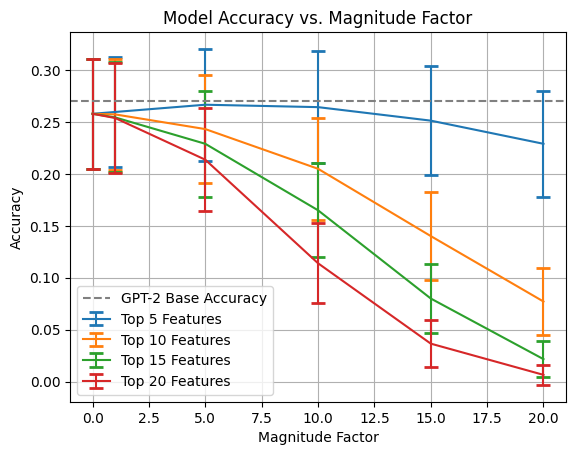

In [20]:
# Plot Accuracy vs Magnitude Factor with 95% Confidence Bars
for i in range(len(results)):
  l, u = normal_ci(results[i], num_prompts_to_analyse)
  err = np.array([np.array(results[i]) - l, u - np.array(results[i])])
  plt.errorbar(mag_factors,
               results[i],
               yerr=err,
               label=f'Top {k_vals[i]} Features',
               capsize=5,
               capthick=2,
               elinewidth=1.5)

plt.axhline(y=gpt2_accuracy, color='gray', linestyle='--', label='GPT-2 Base Accuracy')
plt.xlabel('Magnitude Factor')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs. Magnitude Factor')
plt.grid(True)
plt.legend()
plt.show()